In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px

import scipy.stats as stats

In [3]:
BASE_PATH = '/content/drive/Shared drives/Citadel Datathon 2020 Summer/datasets'
LONDON_EARNINGS_BOROUGH_CSV = 'london_earnings_by_borough.csv'
LONDON_ECONOMIC_ACTIVITY = 'london_economic_activity.csv'
LONDON_TAX_PAYER_INCOME = 'london_taxpayer_income.csv'
UK_INFLATION_CSV = 'UK_inflation.csv'
LONDON_INFRA = 'london_infrastructure_spending.csv'

### Infrastructure Spending

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
london_infra = pd.read_csv(os.path.join(BASE_PATH,LONDON_INFRA), encoding = "ISO-8859-1")
# london_infra

### Inflation

In [9]:
london_inflation = pd.read_csv(os.path.join(BASE_PATH, UK_INFLATION_CSV))
london_inflation

,year,inflation,multiplier
0,2018,NaN,1.00
1,2017,0.036,1.04
2,2016,0.018,1.05
3,2015,0.010,1.07
4,2014,0.024,1.09
...,...,...,...
263,1755,-0.060,203.00
264,1754,0.051,214.00
265,1753,-0.027,208.00
266,1752,0.047,218.00


### Earinings by Borough

In [10]:
london_earnings_borough = pd.read_csv(os.path.join(BASE_PATH,LONDON_EARNINGS_BOROUGH_CSV))
london_earnings_borough

,year,area_code,area,identity,pay_type,pay,confidence
0,2002,00AA,City of London,Female,Hourly,NaN,NaN
1,2003,00AA,City of London,Female,Hourly,NaN,NaN
2,2004,00AA,City of London,Female,Hourly,NaN,NaN
3,2005,00AA,City of London,Female,Hourly,NaN,NaN
4,2006,00AA,City of London,Female,Hourly,NaN,NaN
...,...,...,...,...,...,...,...
6763,2015,926,United Kingdom,Part-Time,Weekly,166.5,0.5
6764,2016,926,United Kingdom,Part-Time,Weekly,177.1,0.5
6765,2017,926,United Kingdom,Part-Time,Weekly,182.0,0.5
6766,2018,926,United Kingdom,Part-Time,Weekly,187.3,0.2


In [11]:
# london_earnings_borough[['pay_type', 'pay']].groupby(['pay_type']).mean()
london_earnings_borough.columns

Index(['year', 'area_code', 'area', 'identity', 'pay_type', 'pay',
       'confidence'],
      dtype='object')

In [12]:
def scale_to_week(pay_type, pay):
  if pay_type == "Hourly":
      return pay*40
  elif pay_type == "Weekly":
    return pay 

In [13]:
london_earnings_borough['pay_weekly'] = london_earnings_borough.apply(lambda x: scale_to_week(x['pay_type'], x['pay']), axis=1)

In [14]:
london_earnings_borough = london_earnings_borough[['year', 'area_code', 'area', 'identity', 'pay', 'pay_weekly', 'confidence']]
london_earnings_borough.tail()

,year,area_code,area,identity,pay,pay_weekly,confidence
6763,2015,926,United Kingdom,Part-Time,166.5,166.5,0.5
6764,2016,926,United Kingdom,Part-Time,177.1,177.1,0.5
6765,2017,926,United Kingdom,Part-Time,182.0,182.0,0.5
6766,2018,926,United Kingdom,Part-Time,187.3,187.3,0.2
6767,2019,926,United Kingdom,Part-Time,196.9,196.9,0.3


In [15]:
england_big_region = ['North East',
       'North West', 'Yorkshire and The Humber', 'East Midlands',
       'West Midlands', 'East', 'London', 'South East', 'South West',
       'Wales', 'Scotland', 'Northern Ireland']

In [16]:
# shrink to full-time
london_earnings_boroug_fulltime = london_earnings_borough[london_earnings_borough['identity']=="Full-time"]
london_earnings_boroug_fulltime = london_earnings_boroug_fulltime[['year', 'area_code', 'area', 'pay_weekly']]

In [17]:
london_earnings_boroug_fulltime = london_earnings_boroug_fulltime.dropna()
london_earnings_boroug_fulltime = london_earnings_boroug_fulltime[london_earnings_boroug_fulltime['area'].isin(england_big_region)]
london_earnings_boroug_fulltime = pd.DataFrame(london_earnings_boroug_fulltime.groupby(by=['year', 'area_code', 'area']).mean())
london_earnings_boroug_fulltime = london_earnings_boroug_fulltime.reset_index()

In [18]:
fig = px.line(london_earnings_boroug_fulltime, x="year", y="pay_weekly", color="area")
fig.update_layout(title="Full-time Employment Weekly Payment Across Regions Around England")
fig.show()

In [19]:
df_temp = london_earnings_boroug_fulltime.set_index('year')[['area','pay_weekly']]
df_temp

,area,pay_weekly
year,,
2002,Northern Ireland,341.00
2002,Scotland,368.65
2002,Wales,352.75
2002,North East,341.60
2002,North West,371.10
...,...,...
2019,West Midlands,551.20
2019,East,612.60
2019,London,714.00


In [20]:
df_temp = pd.pivot_table(df_temp, index='year',columns='area', values='pay_weekly')
df_temp = df_temp.pct_change()
df_temp1 = df_temp.unstack().reset_index().dropna()
df_temp1.columns=['area', 'year', 'pay_increase']

In [21]:
fig = px.line(df_temp1, x="year", y="pay_increase", color="area")
fig.update_layout(title="Full-time Employment Weekly Payment Change Across Regions Around UK", xaxis_title='Year',
                   yaxis_title='Weekly Payment Increase')
fig.show()

### London Econimic Activity

In [22]:
london_economic_activity = pd.read_csv(os.path.join(BASE_PATH, LONDON_ECONOMIC_ACTIVITY))
london_economic_activity.head()

,year,area_code,area,gender,economically_active,working_age,percent,confidence
0,Jan 2005-Dec 2005,00AA,City of London,F,2400.0,3600.0,64.4,NaN
1,Jan 2006-Dec 2006,00AA,City of London,F,NaN,NaN,NaN,NaN
2,Jan 2007-Dec 2007,00AA,City of London,F,NaN,1400.0,NaN,NaN
3,Jan 2008-Dec 2008,00AA,City of London,F,1200.0,1200.0,100.0,NaN
4,Jan 2009-Dec 2009,00AA,City of London,F,NaN,NaN,NaN,NaN


In [23]:
def get_year(date):
  return date[4:8]
london_economic_activity['year'] = london_economic_activity.apply(lambda x: get_year(x['year']), axis=1)
london_economic_activity

,year,area_code,area,gender,economically_active,working_age,percent,confidence
0,2005,00AA,City of London,F,2400.0,3600.0,64.4,NaN
1,2006,00AA,City of London,F,NaN,NaN,NaN,NaN
2,2007,00AA,City of London,F,NaN,1400.0,NaN,NaN
3,2008,00AA,City of London,F,1200.0,1200.0,100.0,NaN
4,2009,00AA,City of London,F,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1465,2015,926,United Kingdom,M,16841300.0,20275800.0,83.1,0.2
1466,2016,926,United Kingdom,M,16920800.0,20374900.0,83.0,0.3
1467,2017,926,United Kingdom,M,17028300.0,20451000.0,83.3,0.3
1468,2018,926,United Kingdom,M,17056000.0,20513300.0,83.1,0.3


In [24]:
london_economic_activity = london_economic_activity[['year', 'area_code', 'area', 'gender', 
                                                     'economically_active', 'percent']]

In [25]:
london_economic_activity = london_economic_activity.dropna()
london_economic_activity_big = london_economic_activity[london_economic_activity['area'].isin(england_big_region)]
london_economic_activity_big = pd.DataFrame(london_economic_activity_big.groupby(by=['year', 'area_code', 'area', 'gender']).mean())
london_economic_activity_big = london_economic_activity_big.reset_index()
london_economic_activity_big

,year,area_code,area,gender,economically_active,percent
0,2005,922,Northern Ireland,F,346500.0,62.0
1,2005,922,Northern Ireland,M,429600.0,78.6
2,2005,923,Scotland,F,1212800.0,71.5
3,2005,923,Scotland,M,1339000.0,82.9
4,2005,924,Wales,F,633100.0,66.9
...,...,...,...,...,...,...
355,2019,H,South East,F,2169400.0,72.1
356,2019,J,South East,M,2370900.0,85.6
357,2019,J,South West,F,2200100.0,78.5
358,2019,K,London,F,1318000.0,78.6


In [26]:
london_economic_activity_big.to_csv('ea.csv', index=False)

In [27]:
fig = px.line(london_economic_activity_big, x="year", y="percent", color="area", line_group="gender")
fig.update_layout(title="Economically Active Working Aged Percentage", xaxis_title='Year',
                   yaxis_title='Percent')
fig.show()

### London Tax Payer Income

In [28]:
london_taxpayer_income = pd.read_csv(os.path.join(BASE_PATH, LONDON_TAX_PAYER_INCOME))
london_taxpayer_income

,year,area_code,area,population,mean_income,median_income
0,1999-2000,00AA,City of London,10000,109800,40400
1,2000-2001,00AA,City of London,10000,137000,65000
2,2001-2002,00AA,City of London,12000,92900,38300
3,2002-2003,00AA,City of London,11000,78700,37000
4,2003-2004,00AA,City of London,10000,85800,39200
...,...,...,...,...,...,...
841,2013-2014,926,United Kingdom,30400000,31300,21900
842,2014-2015,926,United Kingdom,30700000,31800,22400
843,2015-2016,926,United Kingdom,31000000,33400,23200
844,2016-2017,926,United Kingdom,31200000,33500,23600


In [29]:
def get_year(date):
  return date[:4]
london_taxpayer_income['year'] = london_taxpayer_income.apply(lambda x: get_year(x['year']), axis=1)
london_taxpayer_income

,year,area_code,area,population,mean_income,median_income
0,1999,00AA,City of London,10000,109800,40400
1,2000,00AA,City of London,10000,137000,65000
2,2001,00AA,City of London,12000,92900,38300
3,2002,00AA,City of London,11000,78700,37000
4,2003,00AA,City of London,10000,85800,39200
...,...,...,...,...,...,...
841,2013,926,United Kingdom,30400000,31300,21900
842,2014,926,United Kingdom,30700000,31800,22400
843,2015,926,United Kingdom,31000000,33400,23200
844,2016,926,United Kingdom,31200000,33500,23600


In [30]:
london_taxpayer_income = london_taxpayer_income.replace(to_replace="East of England", value="East")

In [31]:
london_taxpayer_income_median = london_taxpayer_income[['year', 'area_code', 'area', 'population', 'median_income']]

In [32]:

london_taxpayer_income_median_big =london_taxpayer_income_median[london_taxpayer_income_median['area'].isin(england_big_region)]

In [33]:
london_taxpayer_income_median_big

,year,area_code,area,population,median_income
594,1999,A,North East,1090000,12900
595,2000,A,North East,1160000,13200
596,2001,A,North East,1180000,14200
597,2002,A,North East,1190000,14400
598,2003,A,North East,1170000,14800
...,...,...,...,...,...
823,2013,922,Northern Ireland,730000,20100
824,2014,922,Northern Ireland,738000,20900
825,2015,922,Northern Ireland,725000,21600
826,2016,922,Northern Ireland,741000,21400


In [34]:
fig = px.line(london_taxpayer_income_median_big, x="year", y="median_income", color="area")
fig.update_layout(title="Tax payer Income by Year", xaxis_title='Year',
                   yaxis_title='Median Income')
fig.show()

In [35]:
london_taxpayer_income_median_big['year'] = london_taxpayer_income_median_big['year'].astype('int')
london_inflation['year'] = london_inflation['year'].astype('int')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
london_taxpayer_income_median_big = london_taxpayer_income_median_big.merge(london_inflation, on='year', how='left')

In [37]:
# Merge with inflation, adjust the median income
london_taxpayer_income_median_big['median_to_2018'] = london_taxpayer_income_median_big['median_income']* \
                                                london_taxpayer_income_median_big['multiplier']
london_taxpayer_income_median_big.head()

,year,area_code,area,population,median_income,inflation,multiplier,median_to_2018
0,1999,A,North East,1090000,12900,0.015,1.68,21672.0
1,2000,A,North East,1160000,13200,0.030,1.65,21780.0
2,2001,A,North East,1180000,14200,0.018,1.60,22720.0
3,2002,A,North East,1190000,14400,0.017,1.57,22608.0
4,2003,A,North East,1170000,14800,0.029,1.55,22940.0


In [81]:
income_change = {}
for region in england_big_region:
  a = int(london_taxpayer_income_median_big[(london_taxpayer_income_median_big['year']==2001)& \
                                    (london_taxpayer_income_median_big['area']==region)]['median_to_2018'])
  b = int(london_taxpayer_income_median_big[(london_taxpayer_income_median_big['year']==2007)& \
                                    (london_taxpayer_income_median_big['area']==region)]['median_to_2018'])
  c = int(london_taxpayer_income_median_big[(london_taxpayer_income_median_big['year']==2011)& \
                                    (london_taxpayer_income_median_big['area']==region)]['median_to_2018'])
  d = int(london_taxpayer_income_median_big[(london_taxpayer_income_median_big['year']==2017)& \
                                    (london_taxpayer_income_median_big['area']==region)]['median_to_2018'])
  income_change[region] = ((b - a)/a, (c - b)/b)
income_change = pd.DataFrame(income_change)

In [61]:
london_taxpayer_income_median_big['income_chg'] = london_taxpayer_income_median_big['median_to_2018'].pct_change()

In [ ]:
fig = px.line(london_taxpayer_income_median_big, x="year", y="income_chg", color="area")
fig.update_layout(title="Tax Payer Income Across Years", xaxis_title='Year',
                   yaxis_title='Median Income Increase')
fig.show()

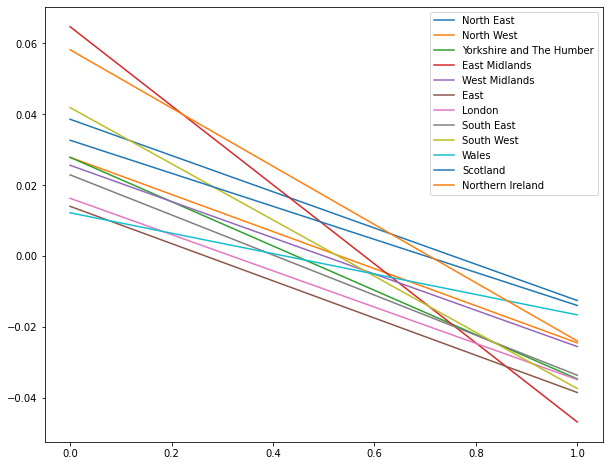

In [82]:
income_change.plot(figsize=(10,8))

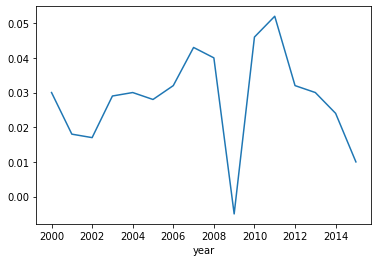

In [77]:
df = london_inflation.set_index('year')
df.loc[range(2000,2016), 'inflation'].plot()

In [69]:
london_inflation.dtypes

year            int64
inflation     float64
multiplier    float64
dtype: object

In [41]:
pd.DataFrame(income_change)*100

,North East,North West,Yorkshire and The Humber,East Midlands,West Midlands,East,London,South East,South West,Wales,Scotland,Northern Ireland
0,3.860035,2.786815,2.786815,6.469828,2.563345,1.405303,1.631757,2.292878,4.190436,1.223958,3.268914,5.820035
1,-0.970462,-2.149015,-3.735788,-4.882393,-2.738090,-3.223638,-1.213310,-2.554083,-2.854382,-1.980962,-1.899263,-5.307251
